### Modelo con embedding

Este modelo es un LSTM que usa el histórico de valores de la acción `AAPL` que corresponde a La empresa __Apple__. Además del histórico de precios se usó un conjunto de noticias relacionadas con la empresa, recopiladas desde el 2012 hasta 2020. Algunos aspectos del conjunto de datos son:
- El histórico de precio es diario, o sea que se tiene el precio de apertura, cierre, máximo, mínimo y volumen por cada día
- Las noticias estan recopiladas desde 2012-07-01 hasta el 2020-02-01 (Aproximadamente 8 años)
- No hay noticias todos los días, y pueden haber más de una noticia el mismo día 

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [23]:
from google.colab import drive

drive.mount('/content/drive')
csv_file_path = '/content/drive/My Drive/ML_Colab/merged_apple_price_news.csv'
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_file_path)

# quedarse solo con el intervalo de fechas que tiene noticias
df = df[df['Date'].between('2012-07-01', '2020-02-01')]
# reset index
df = df.reset_index(drop=True)

print('Shape: ', df.shape)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape:  (1908, 9)


,Date,Close,High,Low,Open,Volume,embedding,SMA_200,EMA_50
0,2012-07-02,17.890991,17.919676,17.621654,17.655775,400092000,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,14.722806,17.292412
1,2012-07-03,18.099030,18.116845,17.935677,17.962248,241712800,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,14.752836,17.324044
2,2012-07-05,18.416981,18.549837,18.106277,18.133753,484383200,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,14.782776,17.366904
3,2012-07-06,18.294384,18.371683,18.164548,18.330920,418930400,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,14.811828,17.403276
4,2012-07-09,18.536249,18.536551,18.240945,18.276876,379405600,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,14.842287,17.447706
...,...,...,...,...,...,...,...,...,...
1903,2020-01-27,75.049576,75.734599,74.060897,75.319211,161940000,[ 0.00357589 0.69842315 0.594802 -0.644040...,55.462338,69.933026
1904,2020-01-28,77.172661,77.345131,75.836611,75.936208,162234000,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,55.609115,70.216933
1905,2020-01-29,78.788063,79.640708,78.069027,78.814788,216229200,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,55.764064,70.553056
1906,2020-01-30,78.673889,78.727331,77.430150,77.864975,126743200,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,55.918011,70.871520


## Pre-procesamiento

1. Partición en train/val/test (80%, 10%, 10%)
2. Generación del dataset supervisado: entrada y salida del modelo
3. Escalamiento

In [24]:
# Convertir nuevamente los embeddings de formato string a un array de floats
df['embedding'] = df['embedding'].apply(lambda x: list(map(float, x.strip('[]').split())))
df

,Date,Close,High,Low,Open,Volume,embedding,SMA_200,EMA_50
0,2012-07-02,17.890991,17.919676,17.621654,17.655775,400092000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.722806,17.292412
1,2012-07-03,18.099030,18.116845,17.935677,17.962248,241712800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.752836,17.324044
2,2012-07-05,18.416981,18.549837,18.106277,18.133753,484383200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.782776,17.366904
3,2012-07-06,18.294384,18.371683,18.164548,18.330920,418930400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.811828,17.403276
4,2012-07-09,18.536249,18.536551,18.240945,18.276876,379405600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.842287,17.447706
...,...,...,...,...,...,...,...,...,...
1903,2020-01-27,75.049576,75.734599,74.060897,75.319211,161940000,"[0.00357589, 0.69842315, 0.594802, -0.64404035...",55.462338,69.933026
1904,2020-01-28,77.172661,77.345131,75.836611,75.936208,162234000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",55.609115,70.216933
1905,2020-01-29,78.788063,79.640708,78.069027,78.814788,216229200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",55.764064,70.553056
1906,2020-01-30,78.673889,78.727331,77.430150,77.864975,126743200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",55.918011,70.871520


In [25]:
# Convertir la columna 'embedding' en múltiples columnas
embedding_cols = [f'pca_{i}' for i in range(len(df.loc[0, 'embedding']))]
df[embedding_cols] = pd.DataFrame(df['embedding'].tolist(), index=df.index)
df

<ipython-input-25-6628ee18cc1b>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[embedding_cols] = pd.DataFrame(df['embedding'].tolist(), index=df.index)
<ipython-input-25-6628ee18cc1b>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[embedding_cols] = pd.DataFrame(df['embedding'].tolist(), index=df.index)
<ipython-input-25-6628ee18cc1b>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

,Date,Close,High,Low,Open,Volume,embedding,SMA_200,EMA_50,pca_0,...,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99
0,2012-07-02,17.890991,17.919676,17.621654,17.655775,400092000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.722806,17.292412,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2012-07-03,18.099030,18.116845,17.935677,17.962248,241712800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.752836,17.324044,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2012-07-05,18.416981,18.549837,18.106277,18.133753,484383200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.782776,17.366904,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2012-07-06,18.294384,18.371683,18.164548,18.330920,418930400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.811828,17.403276,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2012-07-09,18.536249,18.536551,18.240945,18.276876,379405600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.842287,17.447706,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,2020-01-27,75.049576,75.734599,74.060897,75.319211,161940000,"[0.00357589, 0.69842315, 0.594802, -0.64404035...",55.462338,69.933026,0.003576,...,0.080829,0.423057,0.513946,0.418265,0.162755,-0.128037,-0.553787,0.528017,0.470647,-0.168621
1904,2020-01-28,77.172661,77.345131,75.836611,75.936208,162234000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",55.609115,70.216933,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1905,2020-01-29,78.788063,79.640708,78.069027,78.814788,216229200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",55.764064,70.553056,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1906,2020-01-30,78.673889,78.727331,77.430150,77.864975,126743200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",55.918011,70.871520,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
# eliminamos las variables que sobran
df = df.drop(columns=['Date', 'SMA_200', 'EMA_50', 'embedding'])
df

,Close,High,Low,Open,Volume,pca_0,pca_1,pca_2,pca_3,pca_4,...,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99
0,17.890991,17.919676,17.621654,17.655775,400092000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,18.099030,18.116845,17.935677,17.962248,241712800,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,18.416981,18.549837,18.106277,18.133753,484383200,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,18.294384,18.371683,18.164548,18.330920,418930400,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,18.536249,18.536551,18.240945,18.276876,379405600,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,75.049576,75.734599,74.060897,75.319211,161940000,0.003576,0.698423,0.594802,-0.64404,0.554095,...,0.080829,0.423057,0.513946,0.418265,0.162755,-0.128037,-0.553787,0.528017,0.470647,-0.168621
1904,77.172661,77.345131,75.836611,75.936208,162234000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1905,78.788063,79.640708,78.069027,78.814788,216229200,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1906,78.673889,78.727331,77.430150,77.864975,126743200,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
print('Dataframe Shape: ', df.shape)
print('Dataframe Info: ')
df.info()

Dataframe Shape:  (1908, 105)
Dataframe Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Columns: 105 entries, Close to pca_99
dtypes: float64(104), int64(1)
memory usage: 1.5 MB


### Partición del set en entrenamiento, validación y prueba

A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo **se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos**.

Recordemos además que:
- El set de entrenamiento (*train*) se usará para encontrar los parámetros del modelo
- El set de validación (*val*) para verificar que no haya *under/over-fitting* del modelo y para ajustar sus hiperparámetros
- El set de prueba (*test*) para poner a prueba el mejor modelo encontrado durante el entrenamiento/validación

In [28]:
def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1):
  """
  Split a time series into train, validation and test sets.
  """
  N = dataframe.shape[0]
  train_size = int(tr_size * N)
  val_size = int(vl_size * N)
  test_size = N - train_size - val_size

  train = dataframe[:train_size]
  val = dataframe[train_size:train_size + val_size]
  test = dataframe[train_size + val_size:]

  return train, val, test

In [29]:
tr, vl, ts = train_val_test_split(df)

print(f'Training set size: {tr.shape}')
print(f'Validation set size: {vl.shape}')
print(f'Testing set size: {ts.shape}')

Training set size: (1526, 105)
Validation set size: (190, 105)
Testing set size: (192, 105)


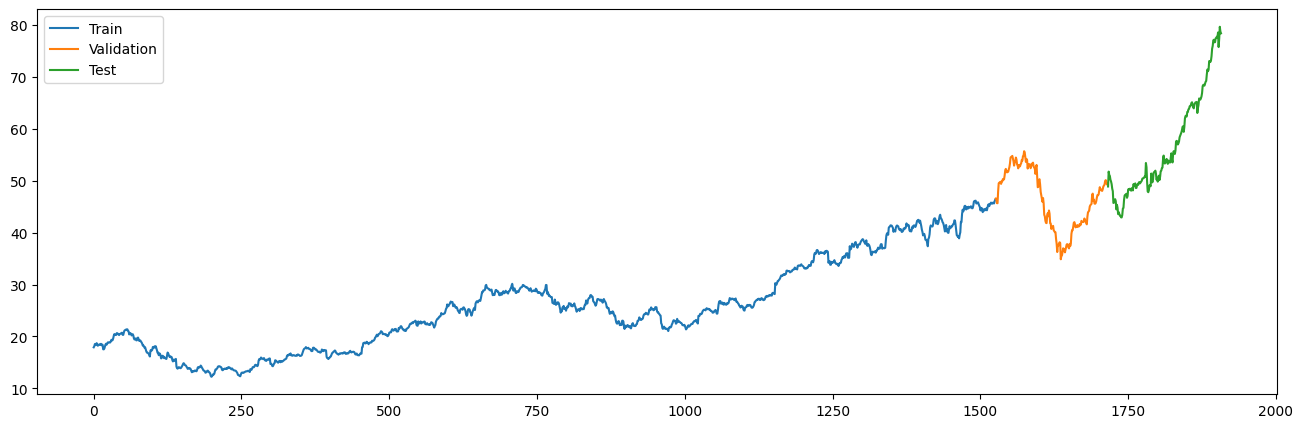

In [30]:
# Dibujar uno de las covariables
covar = 1
col = df.columns[covar]

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Validation')
ax.plot(ts[col], label='Test')
plt.legend()

In [31]:
def create_supervised_dataset(array: np.array, input_length: int, output_length: int):
  """
  Creates a supervised dataset with inputs (X) and outputs (Y) requires for LSTM networks.

  Args:
    array (numpy.ndarray): The input array with size N x features (N:amount of data, f: amount of features).
    input_length (int): Consecutive time instants of the time serie(s) used to feed the model
    output_length (int): Instants of time to be forecast (model output)

  Returns:
    numpy.ndarray: Instants of time to be forecast (model output)
  """

  X, Y = [], []
  shape = array.shape
  if len(shape) == 1:
    # we have a single time serie (univariado)
    rows, cols = array.shape[0], 1
    array = array.reshape(rows, cols)
  else:
    # we have multiple time series (multivariado)
    rows, cols = array.shape

  for i in range(rows - input_length - output_length):
    x = array[i:i + input_length, 0:cols]
    y = array[i + input_length:i + input_length + output_length, -1].reshape(output_length, 1)
    X.append(x)
    Y.append(y)

  X = np.array(X)
  Y = np.array(Y)

  return X, Y

In [32]:
INPUT_LENGTH = 12 # 12 days
OUTPUT_LENGTH = 4 # 4 days

x_tr, y_tr = create_supervised_dataset(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = create_supervised_dataset(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = create_supervised_dataset(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Training Set - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Validation Set - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Testing Set - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Training Set - x_tr: (1510, 12, 105), y_tr: (1510, 4, 1)
Validation Set - x_vl: (174, 12, 105), y_vl: (174, 4, 1)
Testing Set - x_ts: (176, 12, 105), y_ts: (176, 4, 1)


### Escalamiento

Es requerido para garantizar que todas las características se encuentran en el mismo rango de valores, lo que facilita el entrenamiento del modelo y las predicciones:

In [33]:
from sklearn.preprocessing import MinMaxScaler

def scale_dataset(data_input, col_ref):
  '''Escala el dataset en el rango de -1 a 1.

  Entradas:
  - data_input: diccionario con los dataset de entrada y salida del modelo
  (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                  'y_ts':y_ts})
  - col_ref: parámetro adicional para especificar la columna que se predicirá

  Retorna:
  - data_scaled: diccionario con los datasets de entrada y salida escalados
    (tiene la misma estructura del diccionario de entrada)
  - scaler: el escalador usado (requerido para las predicciones)
  '''

  col_ref = df.columns.get_loc(col_ref)

  NSAMPLES = data_input['x_tr'].shape[1]
  NFEATS = data_input['x_tr'].shape[2]

  # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
  # se tendrá sólo 1 escalador)
  scalers = [MinMaxScaler(feature_range=(-1,1)) for _ in range(NFEATS)]

  # Arreglos que contendrán los datasets escalados
  x_tr_s = np.zeros(data_input['x_tr'].shape)
  x_vl_s = np.zeros(data_input['x_vl'].shape)
  x_ts_s = np.zeros(data_input['x_ts'].shape)
  y_tr_s = np.zeros(data_input['y_tr'].shape)
  y_vl_s = np.zeros(data_input['y_vl'].shape)
  y_ts_s = np.zeros(data_input['y_ts'].shape)

  # Escalamiento: se usarán los min/max del set de entrenamiento para
  # escalar la totalidad de los datasets

  # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
  # a fit_transform o transform debe ser de tamaño nsamples x nfeatures
  # (en este caso 24x13)
  for i in range(NFEATS):
    x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
    x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
    x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

  # Escalamiento Ys
  y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
  y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
  y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

  # Conformar diccionario de salida
  data_scaled = {
      'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
      'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
      'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
  }

  return data_scaled, scalers[col_ref]

In [34]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = scale_dataset(data_in, col_ref='Close')

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


Min x_tr/x_vl/x_ts sin escalamiento: -2.3030398/-1.3783343/-1.3097237
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-1.0/-1.1058941990958786

Min y_tr/y_vl/y_ts sin escalamiento: -0.634460211/-0.283356905/-0.286459714
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-0.3890735631511561/-0.3944725098833538

Max x_tr/x_vl/x_ts sin escalamiento: 1460852400.0/384986800.0/277125600.0
Max x_tr/x_vl/x_ts con escalamiento: 1.0000000000000004/1.5619377120498232/2.910394346138016

Max y_tr/y_vl/y_ts sin escalamiento: 0.5149525/0.1816585/0.09858817
Max y_tr/y_vl/y_ts con escalamiento: 0.9999999999999998/0.4200620946500041/0.2755181389324307


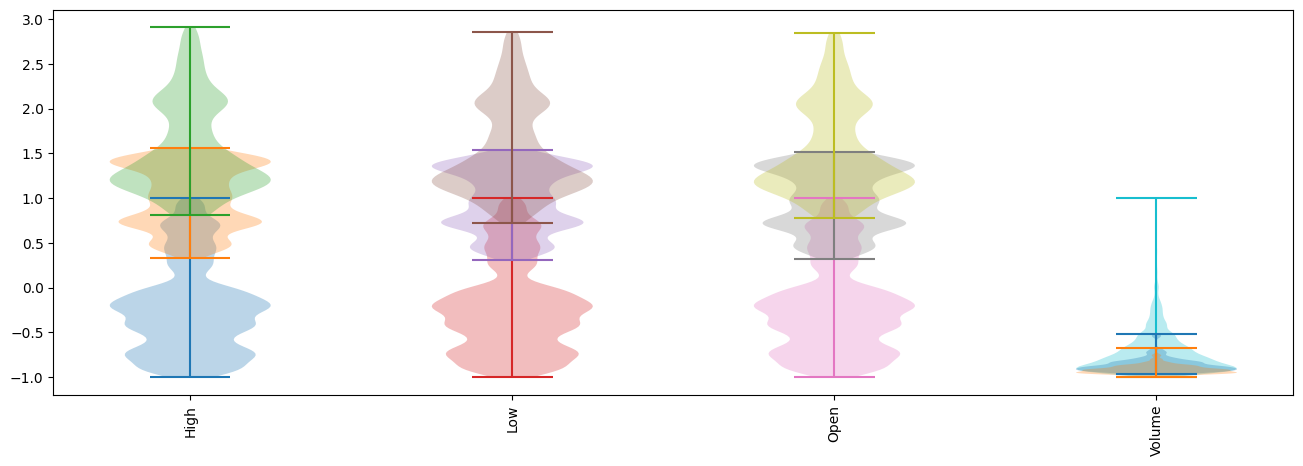

In [35]:
fig, ax = plt.subplots(figsize=(16, 5))
for i in range(1, min(5, df.shape[1])):
  ax.violinplot(dataset=x_tr_s[:, :, i].flatten(), positions=[i])
  ax.violinplot(dataset=x_vl_s[:, :, i].flatten(), positions=[i])
  ax.violinplot(dataset=x_ts_s[:, :, i].flatten(), positions=[i])

ax.set_xticks(list(range(df.shape[1])))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale()

[Text(1, 0, 'y (output)')]

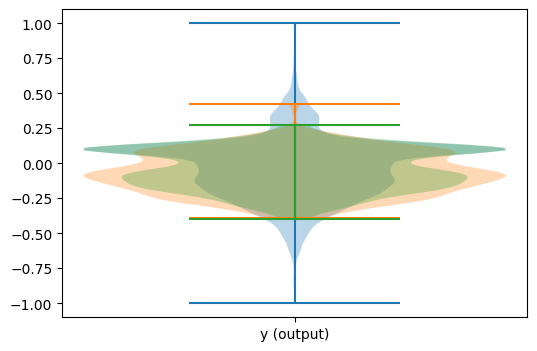

In [36]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())

ax.set_xticks([1])
ax.set_xticklabels(['y (output)'])

## 6. Creación y entrenamiento del modelo

- Entradas: arreglos *x* (batches x input-length  x features = batches x 24 x 4)
- Salidas: arreglos *y* (batches x output-length x features = batches x 1 x 4)

Usaremos la raíz cuadrada del error cuadrático medio (o RMSE por sus siglas en Inglés: *root mean square error*) como pérdida para entrenar el modelo:

$RMSE = \sqrt{\frac{\sum_i (y_i-\hat{y_i})^2}{N}}$

donde:
- $y$: temperatura real
- $\hat{y}$: temperatura predicha
- $N$: cantidad de predicciones

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Adjust parameters for training
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# Model
N_UNITS = 128 # last: 128 |  Size of hidden layer (h) and the memory cell(c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

model = Sequential()
model.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
model.add(Dense(OUTPUT_LENGTH, activation='linear'))

# loss function
def root_mean_squared_error(y_true, y_pred):
  return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred - y_true)))

# Compilation
optimizer = RMSprop(learning_rate=5e-5)
model.compile(
  optimizer=optimizer,
  loss=root_mean_squared_error
)

# Cast the NumPy arrays to float32 before passing to model.fit
x_tr_s = x_tr_s.astype(np.float32)
y_tr_s = y_tr_s.astype(np.float32)
x_vl_s = x_vl_s.astype(np.float32)
y_vl_s = y_vl_s.astype(np.float32)

# Training
EPOCHS = 160
BATCH_SIZE = 256
history = model.fit(
  x = x_tr_s,
  y = y_tr_s,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(x_vl_s, y_vl_s),
  verbose=2
)

Epoch 1/160
6/6 - 4s - loss: 0.2649 - val_loss: 0.2073 - 4s/epoch - 586ms/step
Epoch 2/160
6/6 - 0s - loss: 0.2462 - val_loss: 0.1995 - 405ms/epoch - 67ms/step
Epoch 3/160
6/6 - 0s - loss: 0.2386 - val_loss: 0.1911 - 393ms/epoch - 65ms/step
Epoch 4/160
6/6 - 0s - loss: 0.2338 - val_loss: 0.1844 - 379ms/epoch - 63ms/step
Epoch 5/160
6/6 - 0s - loss: 0.2304 - val_loss: 0.1796 - 391ms/epoch - 65ms/step
Epoch 6/160
6/6 - 0s - loss: 0.2280 - val_loss: 0.1752 - 394ms/epoch - 66ms/step
Epoch 7/160
6/6 - 0s - loss: 0.2262 - val_loss: 0.1736 - 374ms/epoch - 62ms/step
Epoch 8/160
6/6 - 0s - loss: 0.2249 - val_loss: 0.1704 - 395ms/epoch - 66ms/step
Epoch 9/160
6/6 - 0s - loss: 0.2240 - val_loss: 0.1694 - 379ms/epoch - 63ms/step
Epoch 10/160
6/6 - 0s - loss: 0.2233 - val_loss: 0.1684 - 381ms/epoch - 63ms/step
Epoch 11/160
6/6 - 0s - loss: 0.2226 - val_loss: 0.1653 - 424ms/epoch - 71ms/step
Epoch 12/160
6/6 - 0s - loss: 0.2223 - val_loss: 0.1637 - 404ms/epoch - 67ms/step
Epoch 13/160
6/6 - 0s - los

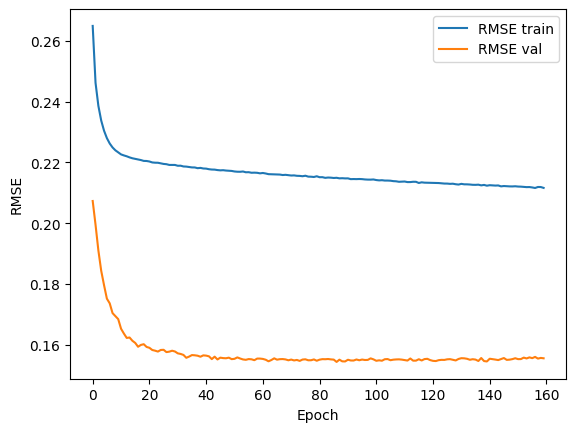

In [38]:
# Plot training and validation curves to check that there is no overfitting
plt.plot(history.history['loss'], label='RMSE train')
plt.plot(history.history['val_loss'], label='RMSE val')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

### Desempeño del modelo

In [39]:
rmse_tr = model.evaluate(x_tr_s, y_tr_s, verbose=0)
rmse_vl = model.evaluate(x_vl_s, y_vl_s, verbose=0)
rmse_ts = model.evaluate(x_ts_s, y_ts_s, verbose=0)

print('Performances:')
print('\tTrain RMSE: %.3f' % rmse_tr)
print('\tValidation RMSE: %.3f' % rmse_vl)
print('\tTest RMSE: %.3f' % rmse_ts)

Performances:
	Train RMSE: 0.207
	Validation RMSE: 0.154
	Test RMSE: 0.212


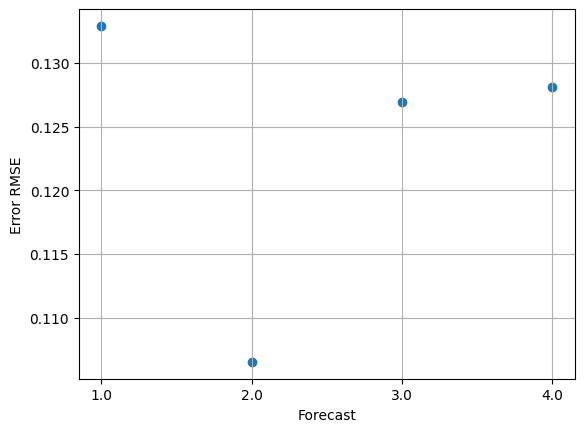

In [44]:
# Generate predictions over test set
y_ts_pred_s = model.predict(x_ts_s, verbose=0)
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# calc RMSE for each predicted instants of time
diff_square = np.square(y_ts.squeeze() - y_ts_pred)
proms = np.mean(diff_square, axis=0)
rmse = np.sqrt(proms)

t = np.linspace(1, 4, 4)

fig, ax = plt.subplots()
ax.scatter(t, rmse)
ax.set_xlabel('Forecast')
ax.set_ylabel('Error RMSE')
plt.xticks(ticks=t, labels=t)
plt.grid()

### Predicciones con el modelo entrenado

In [41]:
def predict(x, model, scaler):
  '''Genera la predicción de OUTPUT_LENGTH instantes
  de tiempo a futuro con el modelo entrenado.

  Entrada:
  - x: batch (o batches) de datos para ingresar al modelo
    (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
  - model: Red LSTM entrenada
  - scaler: escalador (requerido para llevar la predicción a la escala original)

  Salida:
  - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
  '''

  y_pred_s = model.predict(x, verbose=0)
  y_pred = scaler.inverse_transform(y_pred_s)

  return y_pred.flatten()

In [42]:
# Calculate predictions over testing dataset
y_ts_pred = predict(x_ts_s, model, scaler)

Analicemos este desempeño gráficamente mostrando los precios originales y las predichas por el modelo para cada uno de los datos del set de prueba:

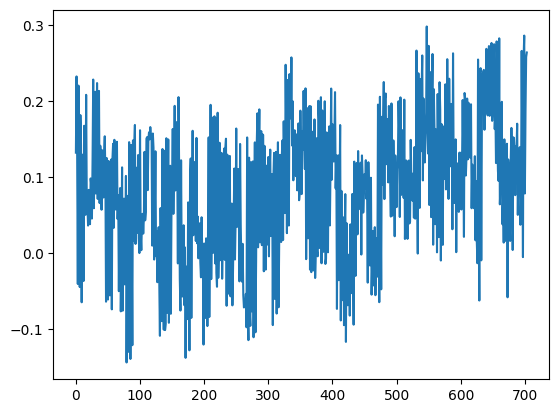

In [43]:
N = len(y_ts_pred)
ndata = np.linspace(1, N, N)

errors = y_ts.flatten() - y_ts_pred.flatten()
plt.plot(errors)